# Partial Distance Correlation using TensorFlow😺

## Install required packages

In [1]:
#!pip install torch torchvision timm
#!pip install transformers
#!pip install torchshow
%pip install albumentations
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.3 MB/s 
     |████████████████████████████████| 182 kB 59.3 MB/s 
     |████████████████████████████████| 7.6 MB 44.3 MB/s 


## Import all related packages

In [2]:
import os
import sys
import time
import math
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.transforms as transforms

from scipy.stats import gaussian_kde
#mute warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import albumentations as A
import pandas as pd
#set gpu memory dynamic growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
plt.style.use('ggplot')
#Avoid bug when latex package is not installed. Use default Latex in plt instead.
matplotlib.rcParams['text.usetex'] = False
# matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

## Define Distance Correlation
Compute the distance matrices between the given samples



Compute the correlation between those two distance matrices

In [5]:
class Loss_DC(tf.keras.losses.Loss):
    def __init__(self):
        super(Loss_DC, self).__init__()


    def Distance_Correlation(self, latent, control):
        matrix_a = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(tf.expand_dims(latent,axis=0)  -  tf.expand_dims(latent,1)),axis=-1) + 1e-12)
        matrix_b = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(tf.expand_dims(control,axis=0) -  tf.expand_dims(control,1)),axis=-1) + 1e-12)
        # print((tf.math.reduce_sum(tf.math.square(tf.expand_dims(latent,axis=0)  -  tf.expand_dims(latent,1)),axis=-1)).shape)
        matrix_A = matrix_a - tf.math.reduce_mean(matrix_a, axis = 0, keepdims= True) - tf.math.reduce_mean(matrix_a, axis = 1, keepdims= True) + tf.math.reduce_mean(matrix_a)
        matrix_B = matrix_b - tf.math.reduce_mean(matrix_b, axis = 0, keepdims= True) - tf.math.reduce_mean(matrix_b, axis = 1, keepdims= True) + tf.math.reduce_mean(matrix_b)
        # print(tf.math.reduce_mean(matrix_a, axis = 0, keepdims= True).shape)
        Gamma_XY = tf.math.reduce_sum(matrix_A * matrix_B)/ (matrix_A.shape[0] * matrix_A.shape[1])
        Gamma_XX = tf.math.reduce_sum(matrix_A * matrix_A)/ (matrix_A.shape[0] * matrix_A.shape[1])
        Gamma_YY = tf.math.reduce_sum(matrix_B * matrix_B)/ (matrix_A.shape[0] * matrix_A.shape[1])

        correlation_r = Gamma_XY/tf.math.sqrt(Gamma_XX * Gamma_YY + 1e-9)
        return correlation_r


    def call(self, latent, control):
        #Avoid OOE on GPU
        # with tf.device('/cpu:0'):
        dc_loss = self.Distance_Correlation(latent, control)

        return dc_loss

## Pearson Correlation vs Distance Correlation
This demo shows that Distance Correlation is better compared with Pearson Correlation

In [6]:
def Pearson_Correlation(latent, control):
    batch_size = latent.shape[0]

    up = (latent - tf.math.reduce_mean(latent, axis = 0, keepdims= True) ) * (control - tf.math.reduce_mean(control, axis = 0, keepdims= True) )
    up = tf.math.reduce_sum(up) / batch_size

    down = tf.math.reduce_sum((latent - tf.math.reduce_mean(latent, axis = 0, keepdims= True) ) ** 2 ) * tf.math.reduce_sum((control - tf.math.reduce_mean(control, axis = 0, keepdims= True) ) ** 2)
    down = down / (batch_size ** 2)

    return up/tf.math.sqrt(down)

Here, we will use a special case to obtain the eigenvalues of these two-dimensional datasets.
Then, calculate the standard deviation of x and y from the square root of the variance and multiplaying with the given number of standard deviations.

In [7]:
def confidence_ellipse(x, y, ax, n_std=2.9, facecolor='none', cov=None, **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, lw=3, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Now we compare Pearson Correlation and Distance Correlation.

Pearson Correration: 0.005219310803997464
Distance Correlation: 0.2075156186236954


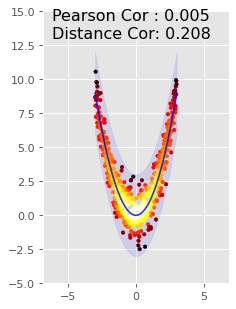

In [8]:
batch_size=10000
Distance_Correlation = Loss_DC()
x = np.linspace(-3, 3, num=batch_size)
y = np.random.randn(batch_size)

y = y + x**2

x = tf.constant(x)
x = tf.reshape(x,[batch_size,-1])
y = tf.constant(y)
y = tf.reshape(y,[batch_size,-1])

pc = Pearson_Correlation(x,y)
dc = Distance_Correlation(x,y)
print(f'Pearson Correration: {pc}')
print(f'Distance Correlation: {dc}')

outR = tf.concat([x,y], axis=-1).numpy()

z = gaussian_kde(outR.transpose())(outR.transpose())
figure(figsize=(3, 4.5), dpi=80)
new_X = np.linspace(-3, 3, num=batch_size)
new_Y_low = new_X**2 - 3
new_Y_high = new_X**2 + 3
plt.plot(new_X, new_X**2, 'b-', alpha=0.8)
ax = plt.gca()
ax.fill_between(new_X, new_Y_low, new_Y_high, color='b' , alpha=0.1)
plt.scatter(x=x[::20], y = y[::20],c=z[::20],s=10,cmap='hot')
ax.axis('equal')
ax.set(xlim=(-5, 5), ylim=(-5, 15))
# ax.set_title(r'$y=x^2+n,n\sim \mathcal{N}(0,1)$'))
plt.text(0.05, 0.95, 'Pearson Cor : {:0.3f}\nDistance Cor: {:0.3f}'.format(pc, dc) , horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, size='x-large')
plt.savefig('pearson_distance1.png', dpi=300)
plt.show()

Pearson Correration: 0.6774770365750868
Distance Correlation: 0.3973150183251239


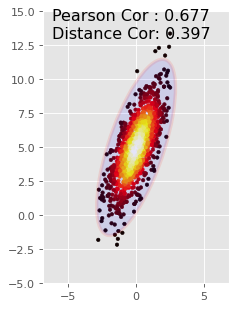

In [9]:
xy = np.random.multivariate_normal(mean=np.asarray([0,5]), cov = np.asarray([[1,1.5],[1.5,5]]), size=batch_size)
x = xy[:,0]
y = xy[:,1]

x = tf.constant(x)
x = tf.reshape(x,[batch_size,-1])
y = tf.constant(y)
y = tf.reshape(y,[batch_size,-1])

pc = Pearson_Correlation(x,y)
dc = Distance_Correlation(x,y)
print(f'Pearson Correration: {pc}')
print(f'Distance Correlation: {dc}')

outR = tf.concat([x,y], axis=-1).numpy()
z = gaussian_kde(outR.transpose())(outR.transpose())

figure(figsize=(3, 4.5), dpi=80)
plt.scatter(x=x[::10], y = y[::10],c=z[::10],s=10,cmap='hot')
ax = plt.gca()
confidence_ellipse(outR[:,0], outR[:,1],ax, cov=np.asarray([[1,1.5],[1.5,5]]), edgecolor="red", facecolor='blue', alpha=0.1)
ax.axis('equal')
ax.set(xlim=(-5, 5), ylim=(-5, 15))
plt.text(0.05, 0.95, 'Pearson Cor : {:0.3f}\nDistance Cor: {:0.3f}'.format(pc, dc) , horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, size='x-large')
plt.savefig('pearson_distance2.png', dpi=300)
plt.show()

Pearson Correration: 0.010300518375578091
Distance Correlation: 0.00027824662754338266


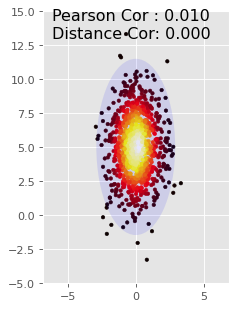

In [10]:
xy = np.random.multivariate_normal(mean=np.asarray([0,5]), cov = np.asarray([[1,0],[0,5]]), size=batch_size)
x = xy[:,0]
y = xy[:,1]

x = tf.constant(x)
x = tf.reshape(x,[batch_size,-1])
y = tf.constant(y)
y = tf.reshape(y,[batch_size,-1])

pc = Pearson_Correlation(x,y)
dc = Distance_Correlation(x,y)
print(f'Pearson Correration: {pc}')
print(f'Distance Correlation: {dc}')

outR = tf.concat([x,y], axis=-1).numpy()
z = gaussian_kde(outR.transpose())(outR.transpose())

figure(figsize=(3, 4.5), dpi=80)
plt.scatter(x=x[::10], y = y[::10],c=z[::10],s=10,cmap='hot')
ax = plt.gca()
confidence_ellipse(outR[:,0], outR[:,1],ax, cov=np.asarray([[1,0],[0,5]]), edgecolor=None, facecolor='blue', alpha=0.1)
ax.axis('equal')
ax.set(xlim=(-5, 5), ylim=(-5, 15))
plt.text(0.05, 0.95, 'Pearson Cor : {:0.3f}\nDistance Cor: {:0.3f}'.format(pc.numpy(), dc) , horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, size='x-large')
plt.savefig('pearson_distance3.png', dpi=300)
plt.show()

## Define Models
We only use the features to evaluate the similarity between networks

In [11]:

def normalize(x):
  #scale range to [0,1] first, in consistence with Pytorch implementation
  x=x/255.0
  mean = x.mean(axis=(0,1,2)).reshape(1,1,-1)
  std = x.std(axis=(0,1,2)).reshape(1,1,-1)
  return (x-mean)/std
    
transforms=A.Compose([
    A.augmentations.RandomCrop(width=32,height=32),#tensorflow does not support RandomCrop with padding
    A.augmentations.HorizontalFlip(0.5)    
])
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
(x_train,y_train),(x_test,y_test)=keras.datasets.cifar10.load_data()
transform = lambda x: transforms(image=x)['image']

for i in range(x_test.shape[0]):
    x_test[i]==transform(x_test[i])
for i in range(x_train.shape[0]):
    x_train[i]==transform(x_train[i])
    
x_train=normalize(x_train)
x_test=normalize(x_test)
print("mean after normalization:",x_train.mean(axis=(0,1,2)))
print("std after normalization:",x_train.std(axis=(0,1,2)))

170498071/170498071 [==============================] - 11s 0us/step
mean after normalization: [-2.71552120e-14  1.88792759e-15  4.94816688e-15]
std after normalization: [1. 1. 1.]


In [12]:
#tensorflow doesn't implement ResNet18
model1=keras.applications.ResNet50(include_top=False,input_shape=(32,32,3),weights='imagenet')
model2=keras.applications.ResNet101(include_top=False,input_shape=(32,32,3),weights='imagenet')
features1 = model1.predict(x_train)
features2 = model2.predict(x_train)
features1 = features1.reshape(features1.shape[0],-1)
features2 = features2.reshape(features2.shape[0],-1)
features1.shape,features2.shape


1563/1563 [==============================] - 30s 18ms/step


((50000, 2048), (50000, 2048))

In [13]:
similarity = Loss_DC()
batch_size=128
sim = 0

for i in range(batch_size,x_train.shape[0],batch_size):
  print(f"\rbatch {int(i/batch_size)}",end="")

  idx = np.arange(i-batch_size,i)
  sim+=similarity(features1[idx],features2[idx]).numpy()


print(f'\rSimilarity between model1 and model2: {sim/len(x_train)*batch_size}')

Similarity between model1 and model2: 0.6641550273132324


## A simple example for partial distance correlation

In [14]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
embed_model = TFBertModel.from_pretrained("bert-base-uncased")

class_embedding = []
for cifar_class in classes:
    encoded_input = tokenizer(cifar_class.lower(), return_tensors='tf')
    output = embed_model(**encoded_input)
    class_embedding.append(output[1])
class_embedding = tf.concat(class_embedding,axis=0)
class_embedding_DF = pd.DataFrame(class_embedding.numpy())
class_embedding_tranp_DF = class_embedding_DF.transpose()
class_embedding_tranp_DF.columns = classes
class_embedding_tranp_DF.head()


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,-0.778572,-0.787241,-0.858110,-0.751022,-0.968879,-0.865062,-0.883761,-0.862523,-0.729765,-0.821767
1,-0.185883,-0.168564,-0.290150,-0.169207,-0.527162,-0.316793,-0.291923,-0.362023,-0.193511,-0.164111
2,0.546288,0.245530,0.357177,0.490521,-0.837614,-0.094327,0.263216,-0.061634,0.524687,0.292495
3,0.596004,0.655340,0.735480,0.570933,0.909102,0.786214,0.742419,0.792160,0.550749,0.696199
4,-0.394308,-0.091688,-0.045644,-0.370888,0.744903,0.057494,0.010459,0.054226,-0.389657,-0.173794


## Definition of the Partial Distance Correlation

In [15]:
def P_Distance_Matrix(latent):
    n = latent.shape[0]
    matrix_a = tf.math.sqrt(tf.math.reduce_sum(tf.square(tf.expand_dims(latent,axis=0) - tf.expand_dims(latent,axis=1) ), axis = -1) + 1e-18)
    matrix_A = matrix_a - tf.math.reduce_sum(matrix_a, axis = 0, keepdims= True)/(n-2) - tf.math.reduce_sum(matrix_a, axis = 1, keepdims= True)/(n-2) \
                + tf.math.reduce_sum(matrix_a)/((n-1)*(n-2))

    diag_A = tf.linalg.diag(tf.linalg.diag(matrix_A) ) 
    matrix_A = matrix_A - diag_A
    return matrix_A


def bracket_op(matrix_A, matrix_B):
    n = matrix_A.shape[0]
    return tf.math.reduce_sum(matrix_A * matrix_B)/(n*(n-3))


def P_removal(matrix_A, matrix_C):
    result = matrix_A - bracket_op(matrix_A, matrix_C) / bracket_op(matrix_C, matrix_C) * matrix_C
    return result

def Correlation(matrix_A, matrix_B):
    Gamma_XY = bracket_op(matrix_A, matrix_B)
    Gamma_XX = bracket_op(matrix_A, matrix_A)
    Gamma_YY = bracket_op(matrix_B, matrix_B)

    correlation_r = Gamma_XY/tf.math.sqrt(Gamma_XX * Gamma_YY + 1e-18)

    return correlation_r


def P_DC(latent_A, latent_B, ground_truth):
    matrix_A = P_Distance_Matrix(latent_A)
    matrix_B = P_Distance_Matrix(latent_B)
    matrix_GT = P_Distance_Matrix(ground_truth)

    matrix_A_B = P_removal(matrix_A, matrix_B)

    cr = Correlation(matrix_A_B, matrix_GT)

    return cr


def New_DC(latent_A, ground_truth):
    matrix_A = P_Distance_Matrix(latent_A)
    matrix_GT = P_Distance_Matrix(ground_truth)
    cr = Correlation(matrix_A, matrix_GT)

    return cr

We will remove model 2 from model 1 and measure the influence of the main networks. 

In [19]:
total_pdc = 0
batch_size=100



for i in range(batch_size,x_train.shape[0],batch_size):
  print(f"\rbatch {int(i/batch_size)}",end="")

  idx = np.arange(i-batch_size,i)

  targets = tf.squeeze(y_train[idx].astype('int32'))
  ground_truth = tf.gather(class_embedding,targets)#uint8 not allowed as index
  total_pdc+=P_DC(features1[idx],features2[idx],ground_truth).numpy()

print("\r Partial Distance after removing model 2 from model 1:",total_pdc/len(x_train)*batch_size)

 Partial Distance after removing model 2 from model 1: 0.04668523239158094
